In [1]:
import math, glob, time, os, re, json
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm

from katrain.core.base_katrain import KaTrainBase
from katrain.core.game import Game, KaTrainSGF
from katrain.core.engine import KataGoEngine

[INFO   ] [Logger      ] Record log in /home/sander/.kivy/logs/kivy_20-06-17_4.txt
[INFO   ] [Kivy        ] v2.0.0rc2, git-78fb93b, 20200429
[INFO   ] [Kivy        ] Installed at "/home/sander/anaconda3/lib/python3.7/site-packages/kivy/__init__.py"
[INFO   ] [Python      ] v3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
[INFO   ] [Python      ] Interpreter at "/home/sander/anaconda3/bin/python"
 /home/sander/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
 A value is trying to be set on a copy of a slice from a DataFrame.
 Try using .loc[row_indexer,col_indexer] = value instead
 
 See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
   
 /home/sander/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
 A value is trying to be set on a copy of a slice from a DataFrame.
 Try using .loc[row_indexer,col_indexer] = value instead
 
 

In [2]:
kt = KaTrainBase(force_package_config=True)

In [3]:
e_config = kt.config("engine")
e_config["max_visits"] = e_config["fast_visits"] = 1 # super quick - maybe inaccurate
e_config["threads"] = 128
e_config["_include_ownership"] = False
e_config["config"] = "./kata_config.cfg"
e_config["model"] = '~/Desktop/g170e-b20c256x2-s5055114240-d1149032340.bin.gz'
e_config

{'katago': '',
 'model': '~/Desktop/g170e-b20c256x2-s5055114240-d1149032340.bin.gz',
 'config': './kata_config.cfg',
 'threads': 128,
 'max_visits': 1,
 'fast_visits': 1,
 'max_time': 3.0,
 'wide_root_noise': 0.0,
 '_enable_ownership': True,
 '_include_ownership': False}

In [4]:
engine = KataGoEngine(kt, e_config)

In [5]:
PLAYERS={'W':'white','B':'black'}

def get_move_stats(game):
    game.redo(999)
    moves = game.current_node.nodes_from_root[1:]  # without root
    while not all(m.analysis_ready for m in moves):
        time.sleep(0.01)

    parent_policy_per_move = [move.parent.policy_ranking for move in moves]
    b_scoreloss = [move.points_lost for move in moves]
    
    
    num_legal_moves = [sum(pv >= 0 for pv,_ in policy_ranking) for policy_ranking in parent_policy_per_move]
    policy_stats = [
        [(move_num+1, num_mv, rank, value, policy_ranking[0][0], move.score, move.points_lost, PLAYERS[mv.player]) 
        for rank, (value, mv) in enumerate(policy_ranking) if mv == move.move][0]
        for move_num,(move, policy_ranking, num_mv) in enumerate(zip(moves, parent_policy_per_move, num_legal_moves))
    ]
    return policy_stats


def rank_to_kyu(r):
    return 30-r

def outlier_free_stats(data):
    sorteddata = sorted(data)
    lendata = len(data)
    selected = sorteddata[int(lendata*.2):int(lendata*.8)+1]
    return np.mean(selected)

def normalized_histogram(data, **args):
    weights = np.ones_like(data) / len(data)
    plt.hist(data, weights=weights, **args)

skipped = defaultdict(int)
skipped['board_size'] = defaultdict(int)
def analyze_game(filename):
    global skipped
    sgf = KaTrainSGF.parse_file(filename)
    gamedata_str = re.search('Gamedata:(.*)SGF with review',sgf.properties['C'][0],re.DOTALL)[1]
    gamedata = json.loads(gamedata_str)
    outcome = gamedata['outcome']
    rank = {p:rank_to_kyu(gamedata['players'][p]['rank']) for p in ['white','black']}
    players = {p:gamedata['players'][p]['username'] for p in ['white','black']}
    ids = {p:gamedata['players'][p]['id'] for p in ['white','black']}
    bot_player = 'black' if 'katrain-' in players['black'] else 'white'
    non_bot_player = 'black' if bot_player=='white' else 'white'
    winner = 'black' if gamedata['winner']==ids['black'] else 'white'
    gameid = gamedata['game_id']
    if sgf.board_size!=(19,19):
        skipped['board_size'][sgf.board_size] += 1
        return

    if outcome == 'Cancellation':
        skipped['cancelled'] += 1
        return

    if outcome == 'Timeout': # often abusers
        skipped['timeout'] += 1
        return
    
    if len(gamedata['moves']) < MIN_MOVES:
        skipped['min_moves'] += 1
        return


    if 'active_game' in gamedata and gamedata['active_game'][non_bot_player]['ratings']['overall']['deviation'] > MAX_DEVIATION:
        skipped['provisional'] += 1
        return

    try:
        game = Game(kt, engine, move_tree=sgf)
        move_analysis =  [ (gameid,*stats,non_bot_player) for stats in get_move_stats(game) ] 
    except Exception as e:
        print(f"Error in analyzing {filename}: {e}") # branching etc
        return

    return gameid, (filename, players[bot_player],rank[bot_player], players[non_bot_player],
            rank[non_bot_player],non_bot_player, winner,outcome,gamedata['ranked']), move_analysis

In [19]:
analyze_games = False
MAX_DEVIATION = 175 # exclude players with a non-established rank
MIN_MOVES = 100 # exclude games with < this many moves

In [20]:
if analyze_games:
    from multiprocessing.pool import ThreadPool
    import threading
    
    games_data = pd.DataFrame(columns=['file','bot','bot_rank','user','user_rank','user_color','winner','outcome','ranked'])
    moves_data = []

    
    files = glob.glob("sgf_ogs/*.sgf")
    pbar = tqdm(total=len(files))
    lock = threading.Lock()

    def process_file(filename):
        result = analyze_game(filename)
        pbar.update(1)
        if result:
            gameid, gamedata_row, move_analysis = result
            with lock:
                games_data.loc[gameid] = gamedata_row
                moves_data.append(move_analysis)            
            
            
    pool = ThreadPool(8)
    pool.map(process_file, files)
    pbar.close()
    
    moves_data = pd.DataFrame( sum(moves_data,[]),    
        columns=['game_id','move','num_legal','policy_rank','policy_value','top_value',
                 'black_score','points_lost','move_color','user_color'])

    games_data.to_csv('games-20b.csv.gz',compression='gzip')
    moves_data.to_csv('moves-20b.csv.gz',compression='gzip')
    print(f"{games_data.shape[0]} games and {moves_data.shape[0]} moves analyzed.\nGames skipped: {dict(skipped)}")
else:
    moves_data = pd.read_csv('moves-20b.csv.gz',index_col=0)
    games_data = pd.read_csv('games-20b.csv.gz',index_col=0)
    print(f"Loaded {games_data.shape[0]} games and {moves_data.shape[0]} moves.")    

Loaded 2431 games and 665119 moves.


In [21]:
plt.rcParams.update({'font.size': 22})

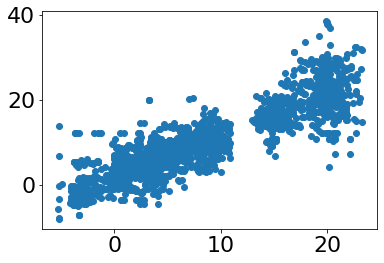

In [9]:
plt.scatter(games_data.bot_rank,games_data.user_rank)

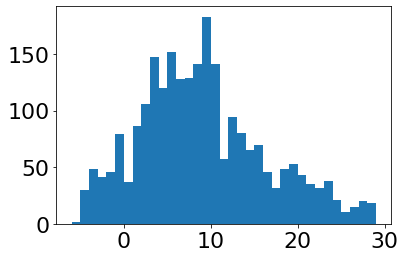

In [10]:
plt.hist(games_data.user_rank,bins=range(-6,30));

In [11]:
moves_data = moves_data.loc[moves_data.game_id.map(lambda x: x in games_data.index)] # race cond?

In [12]:
user_moves = moves_data[moves_data.move_color==moves_data.user_color]
user_moves['rank'] = games_data.loc[user_moves.game_id].user_rank.values

bot_moves = moves_data[moves_data.move_color!=moves_data.user_color]
bot_moves['rank'] = games_data.loc[bot_moves.game_id].bot_rank.values
labels = ['users','bots']

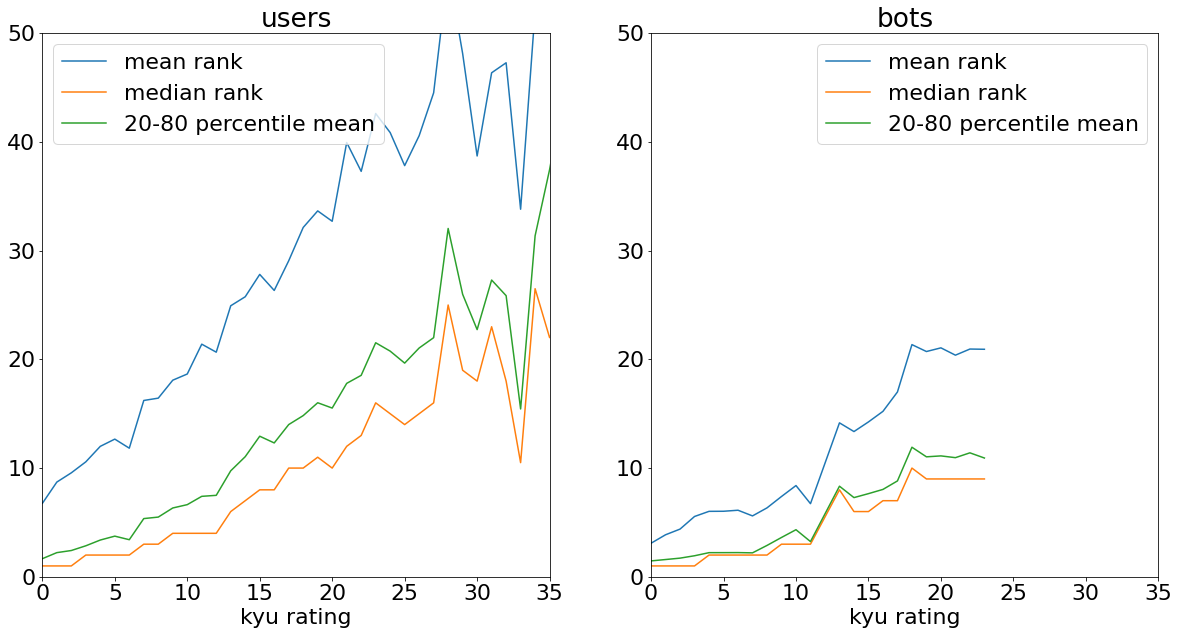

In [13]:
plt.figure(figsize=(20,10))
for i,moves in enumerate([user_moves,bot_moves]):
    stats = [(r,df.policy_rank.mean(),df.policy_rank.median(),outlier_free_stats(df.policy_rank.values),df.shape[0]) 
              for r,df in moves.groupby(moves['rank'].round())]    
    rank, mean, median, outlier_free_mean, sample_size = zip(*stats)
    plt.subplot(1,2,i+1)
    plt.plot(rank,mean,rank,median,rank,outlier_free_mean)
    plt.xlabel('kyu rating')
    plt.legend(['mean rank','median rank','20-80 percentile mean'])
    plt.title(labels[i])
    plt.ylim([0,50])
    plt.xlim([0,35])

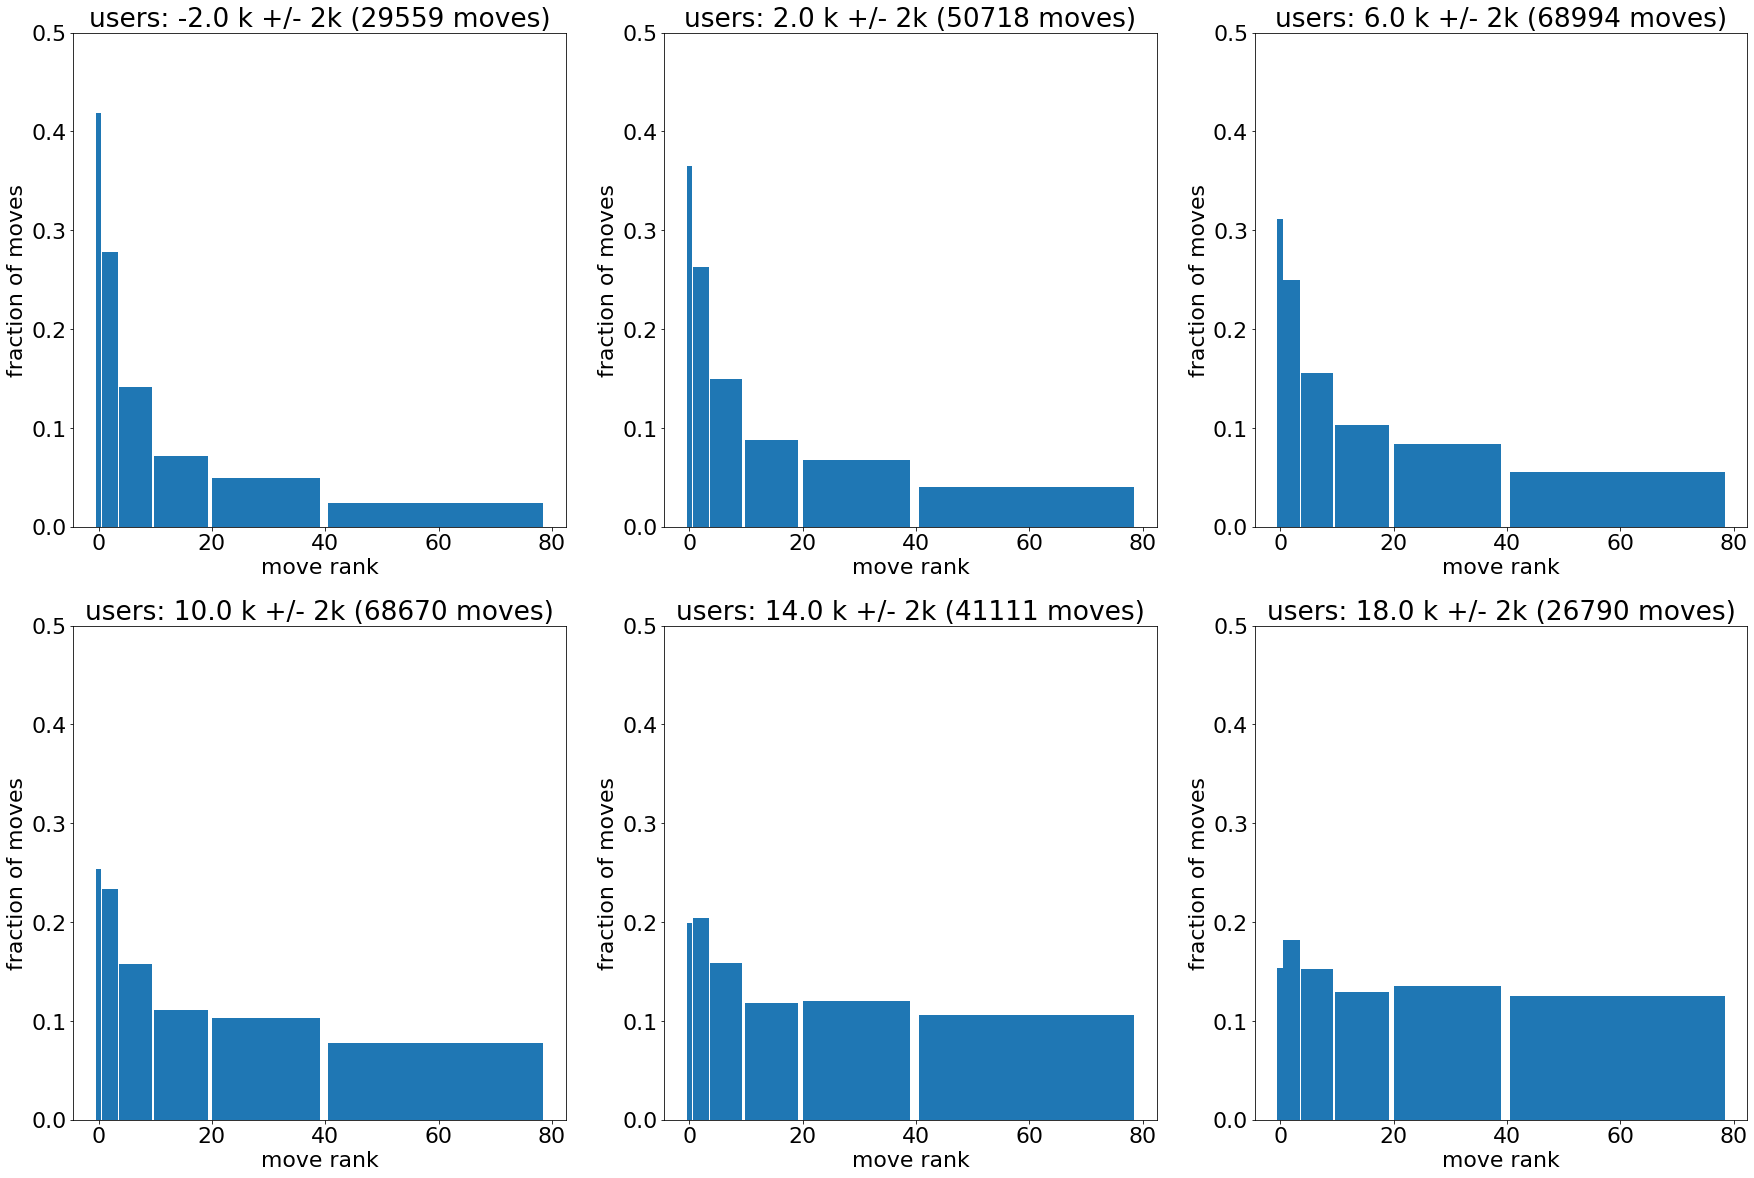

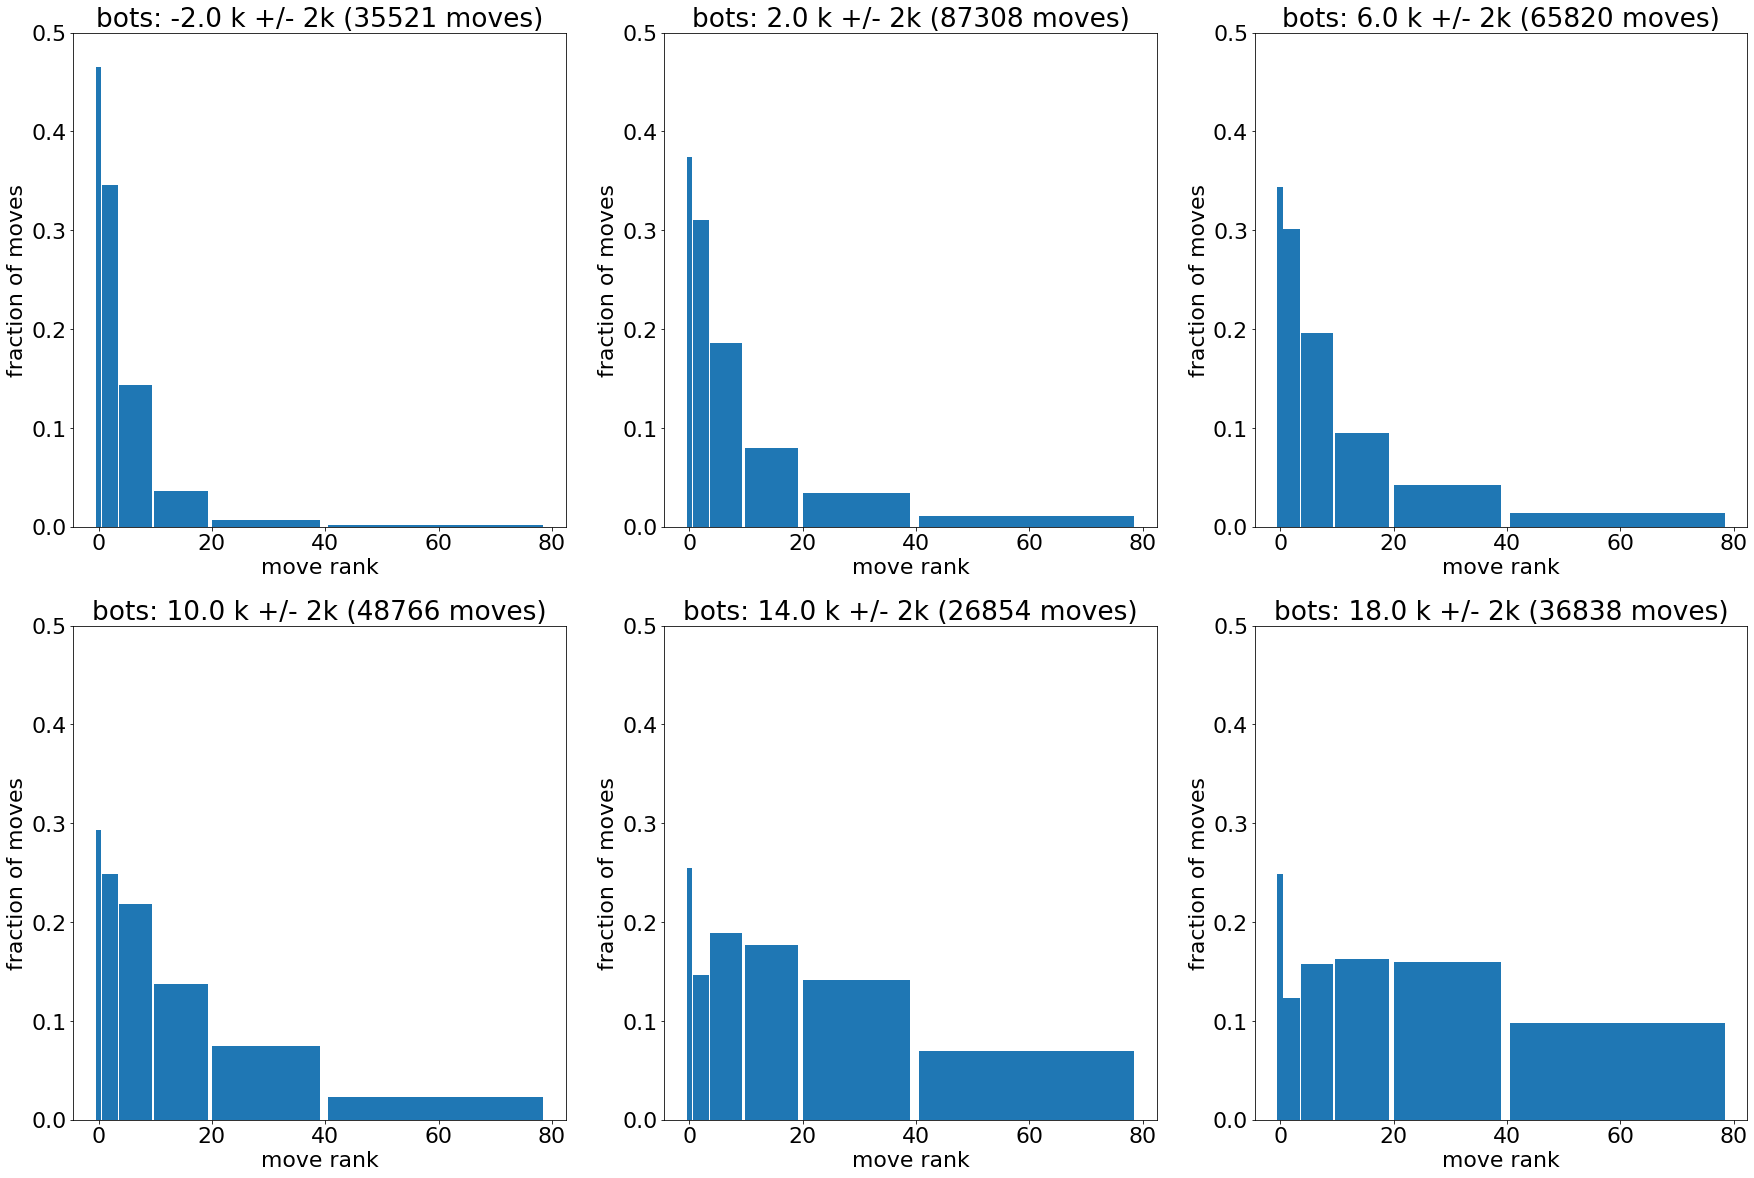

In [14]:
for i,moves in enumerate([user_moves,bot_moves]):
    s = 1
    plt.figure(figsize=(30,20))
    binned_rank = ((moves['rank']-2)/4).round()*4+2
    for r,df in moves[(binned_rank >= -2) & (binned_rank <= 18)].groupby(binned_rank):
        plt.subplot(2, 3, s); s=s+1
        normalized_histogram(df.policy_rank.values,bins=[-0.5,0.5,3.5,9.5,19.5,39.5,79.5],rwidth=0.95)
        plt.title(f"{labels[i]}: {r} k +/- 2k ({df.shape[0]} moves)")
        plt.xlabel('move rank')
        plt.ylabel('fraction of moves')
        plt.ylim([0,0.5])

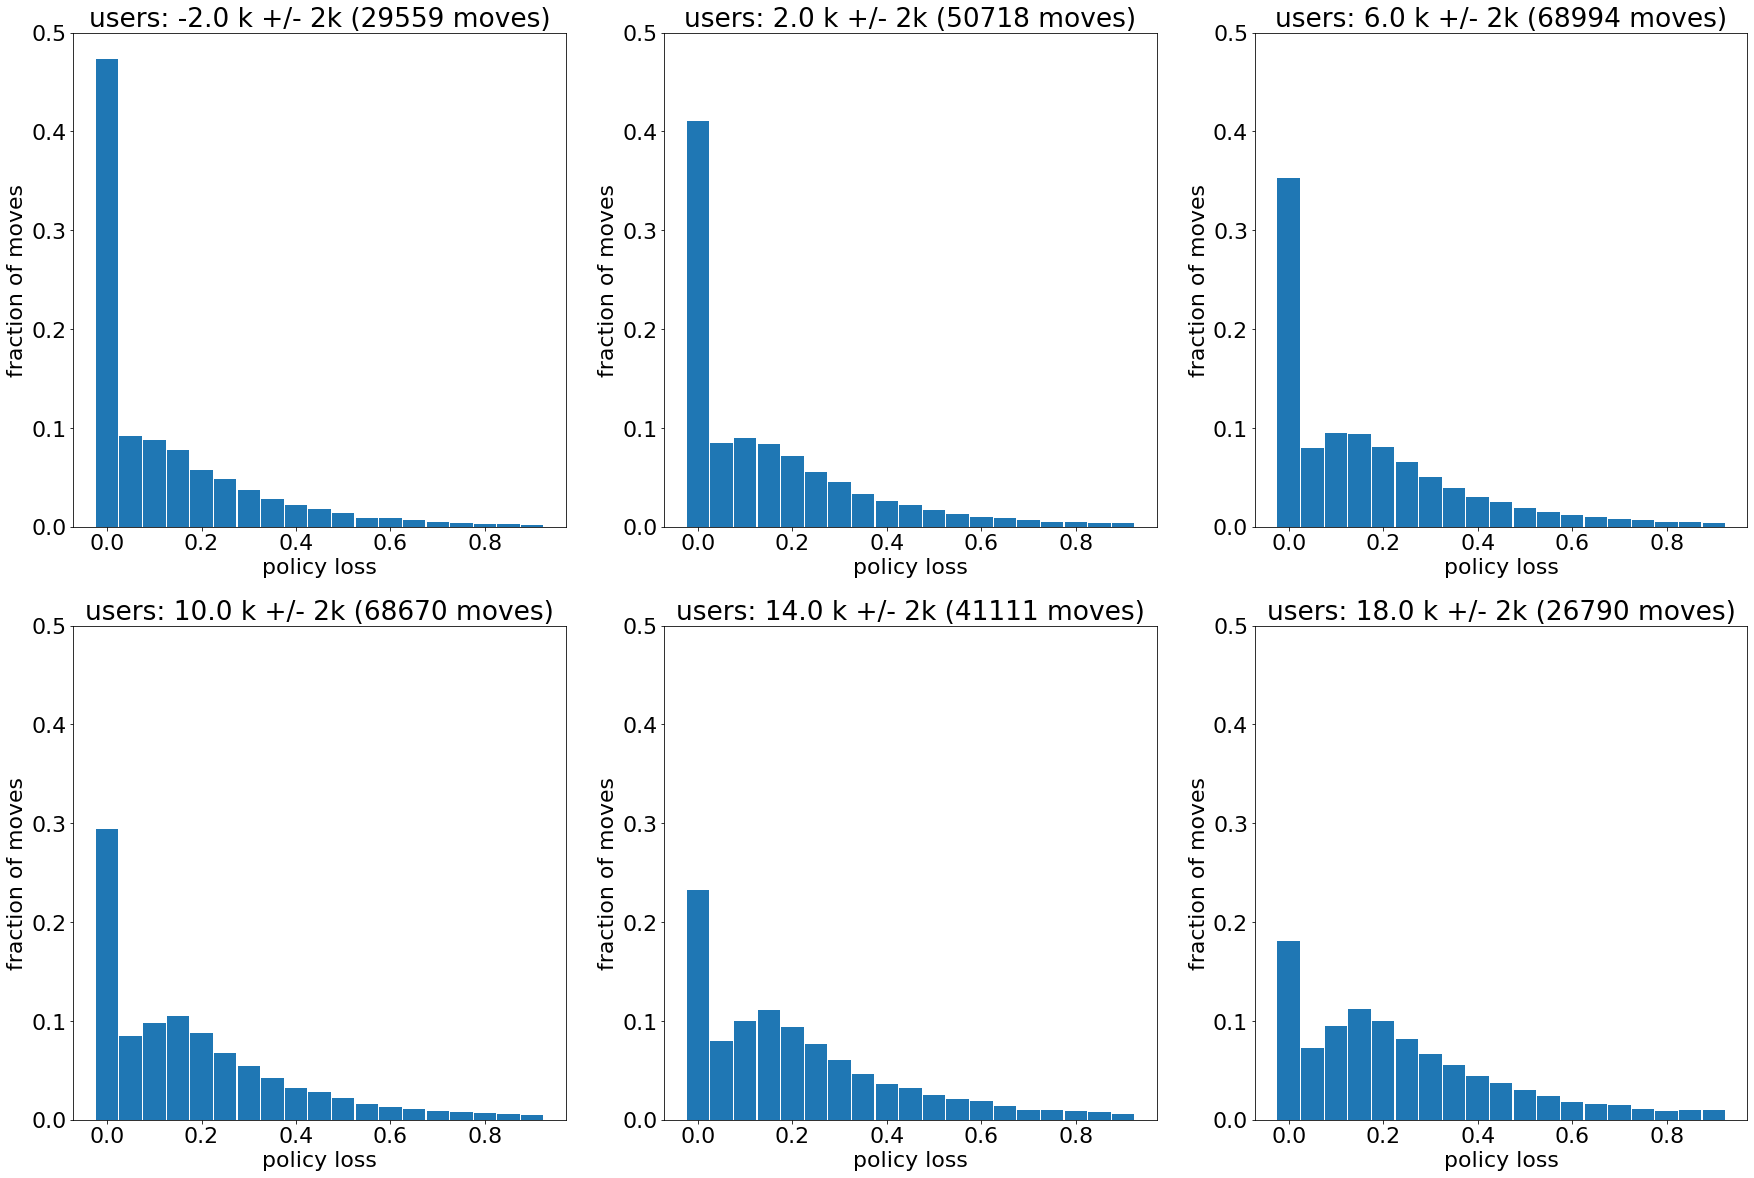

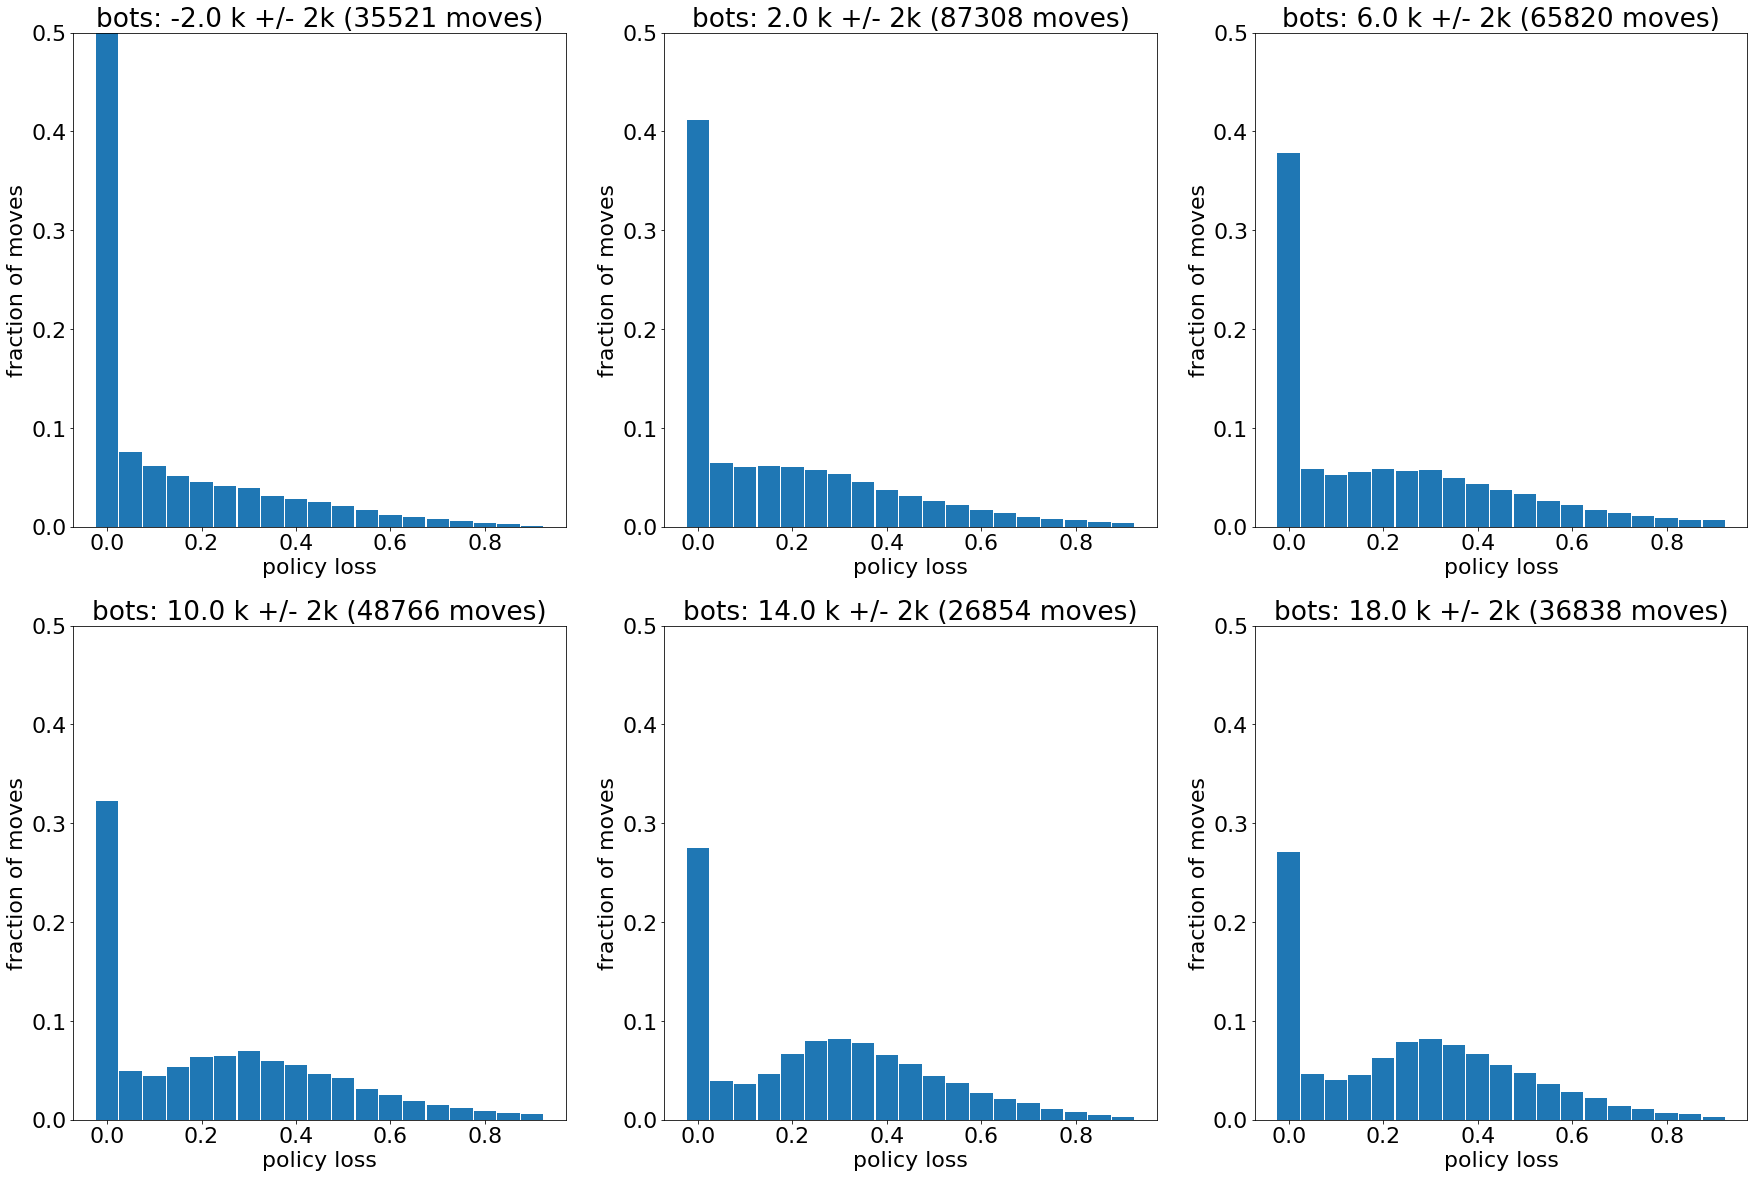

In [15]:
for i,moves in enumerate([user_moves,bot_moves]):
    s = 1
    plt.figure(figsize=(30,20))
    binned_rank = ((moves['rank']-2)/4).round()*4+2
    for r,df in moves[(binned_rank >= -2) & (binned_rank <= 18)].groupby(binned_rank):
        plt.subplot(2, 3, s); s=s+1
        normalized_histogram(df.top_value - df.policy_value,bins=np.arange(-0.025,0.975,0.05),rwidth=0.95)
        plt.title(f"{labels[i]}: {r} k +/- 2k ({df.shape[0]} moves)")
        plt.xlabel('policy loss')
        plt.ylabel('fraction of moves')
        plt.ylim([0,0.5])

Text(0.5, 1.0, 'bot moves top policy value')

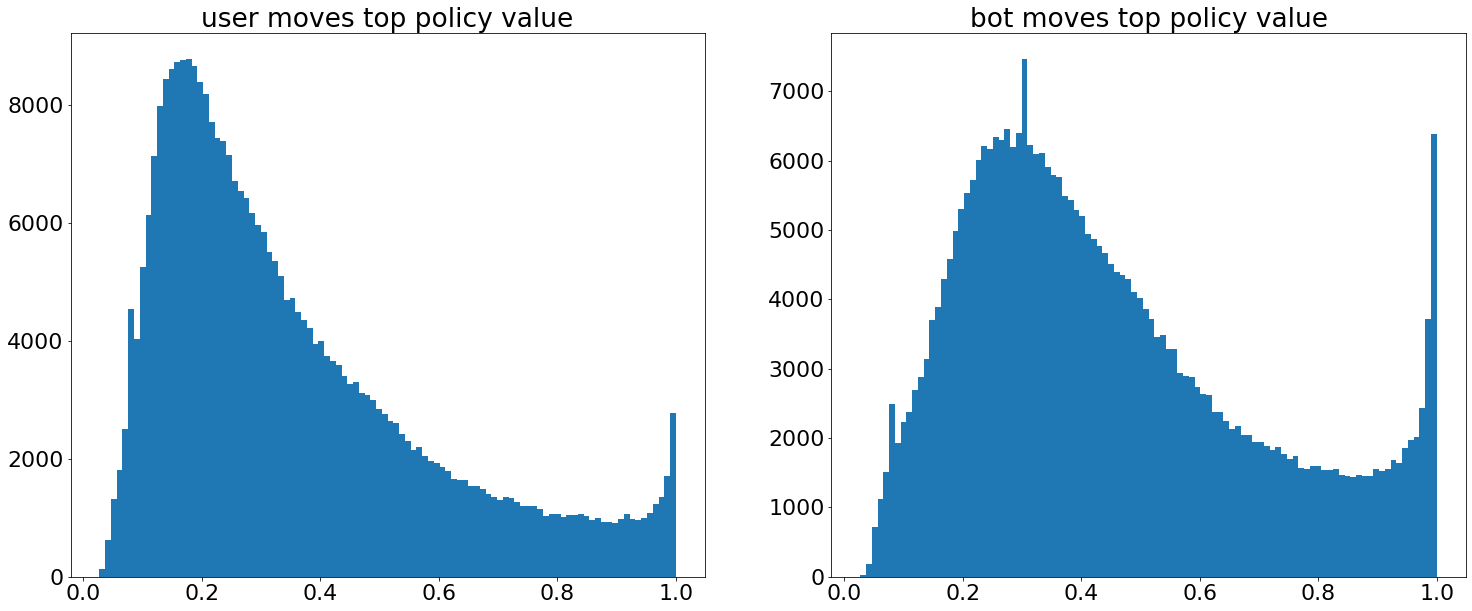

In [16]:
plt.figure(figsize=(25,10))
plt.subplot(1,2,1); plt.hist(user_moves.top_value,bins=100); plt.title('user moves top policy value')
plt.subplot(1,2,2); plt.hist(bot_moves.top_value,bins=100); plt.title('bot moves top policy value')

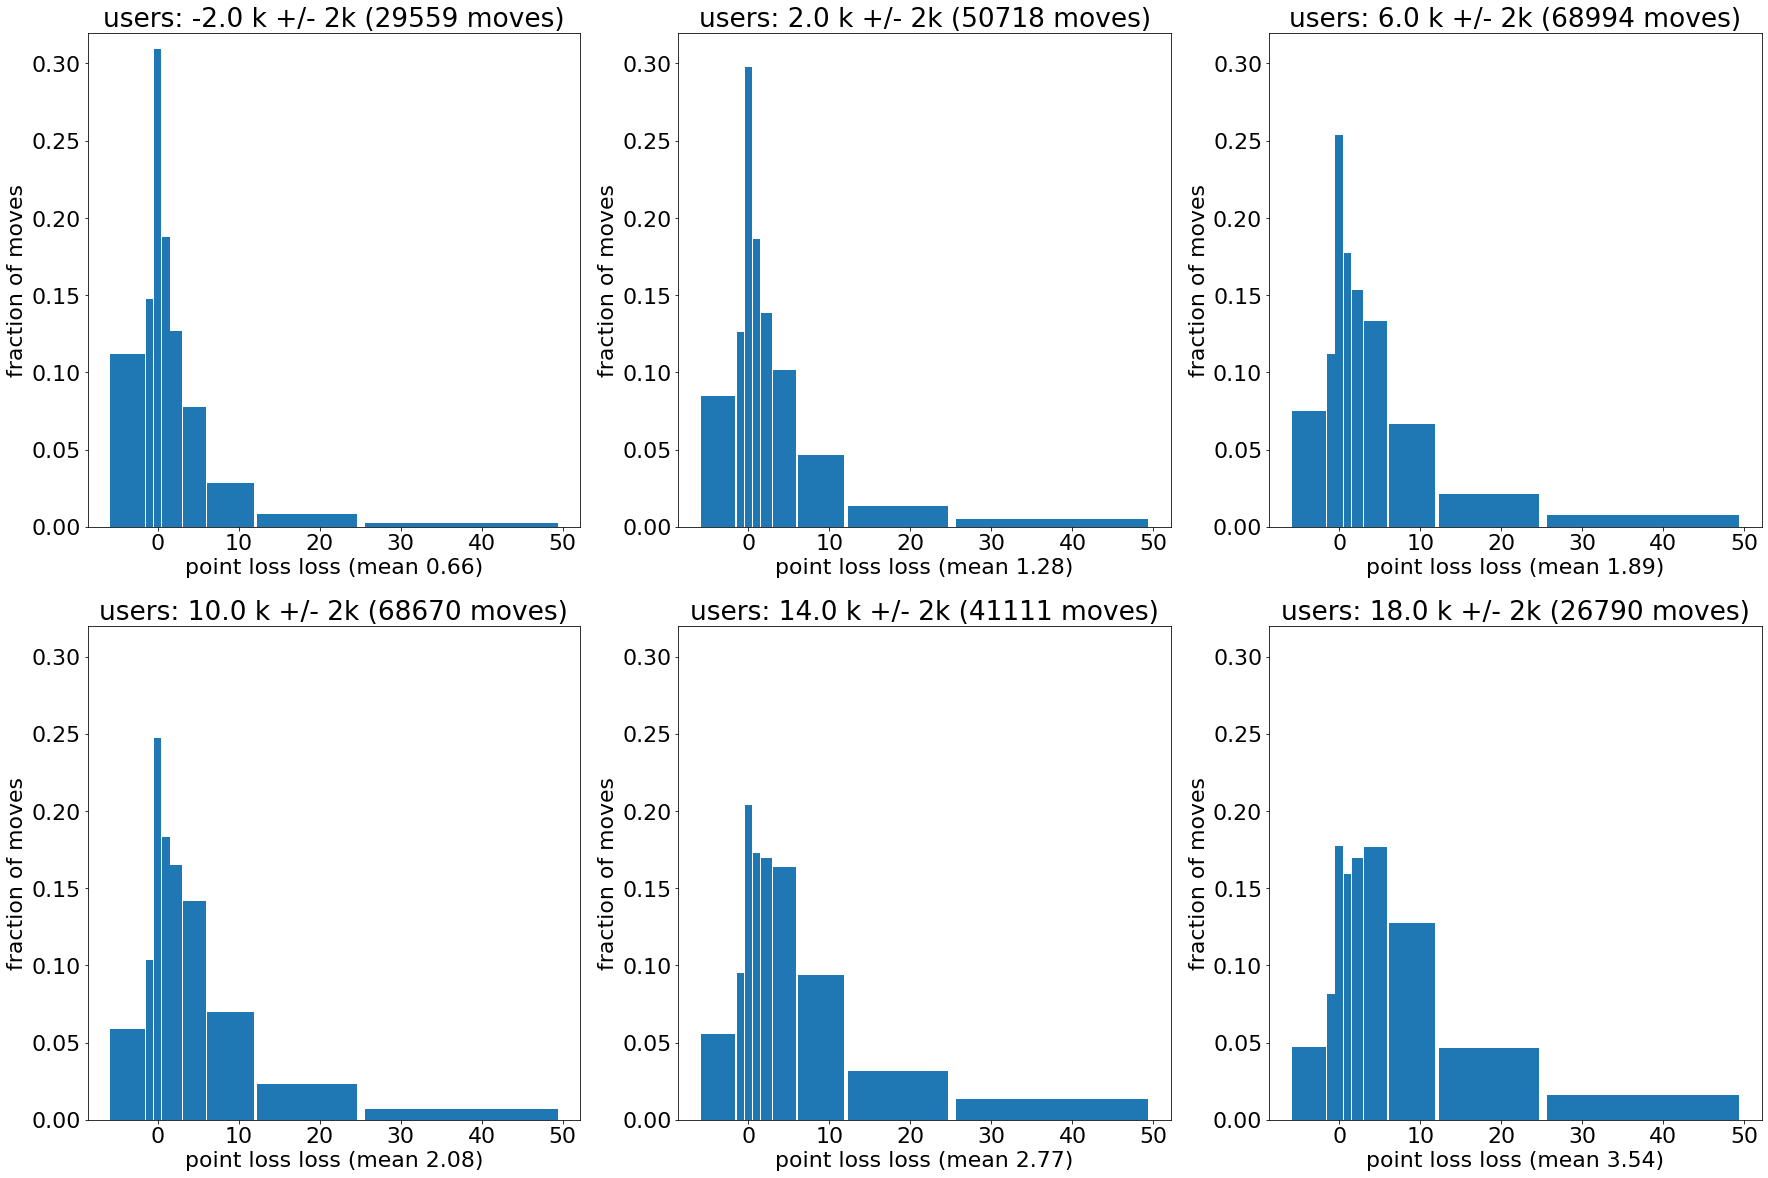

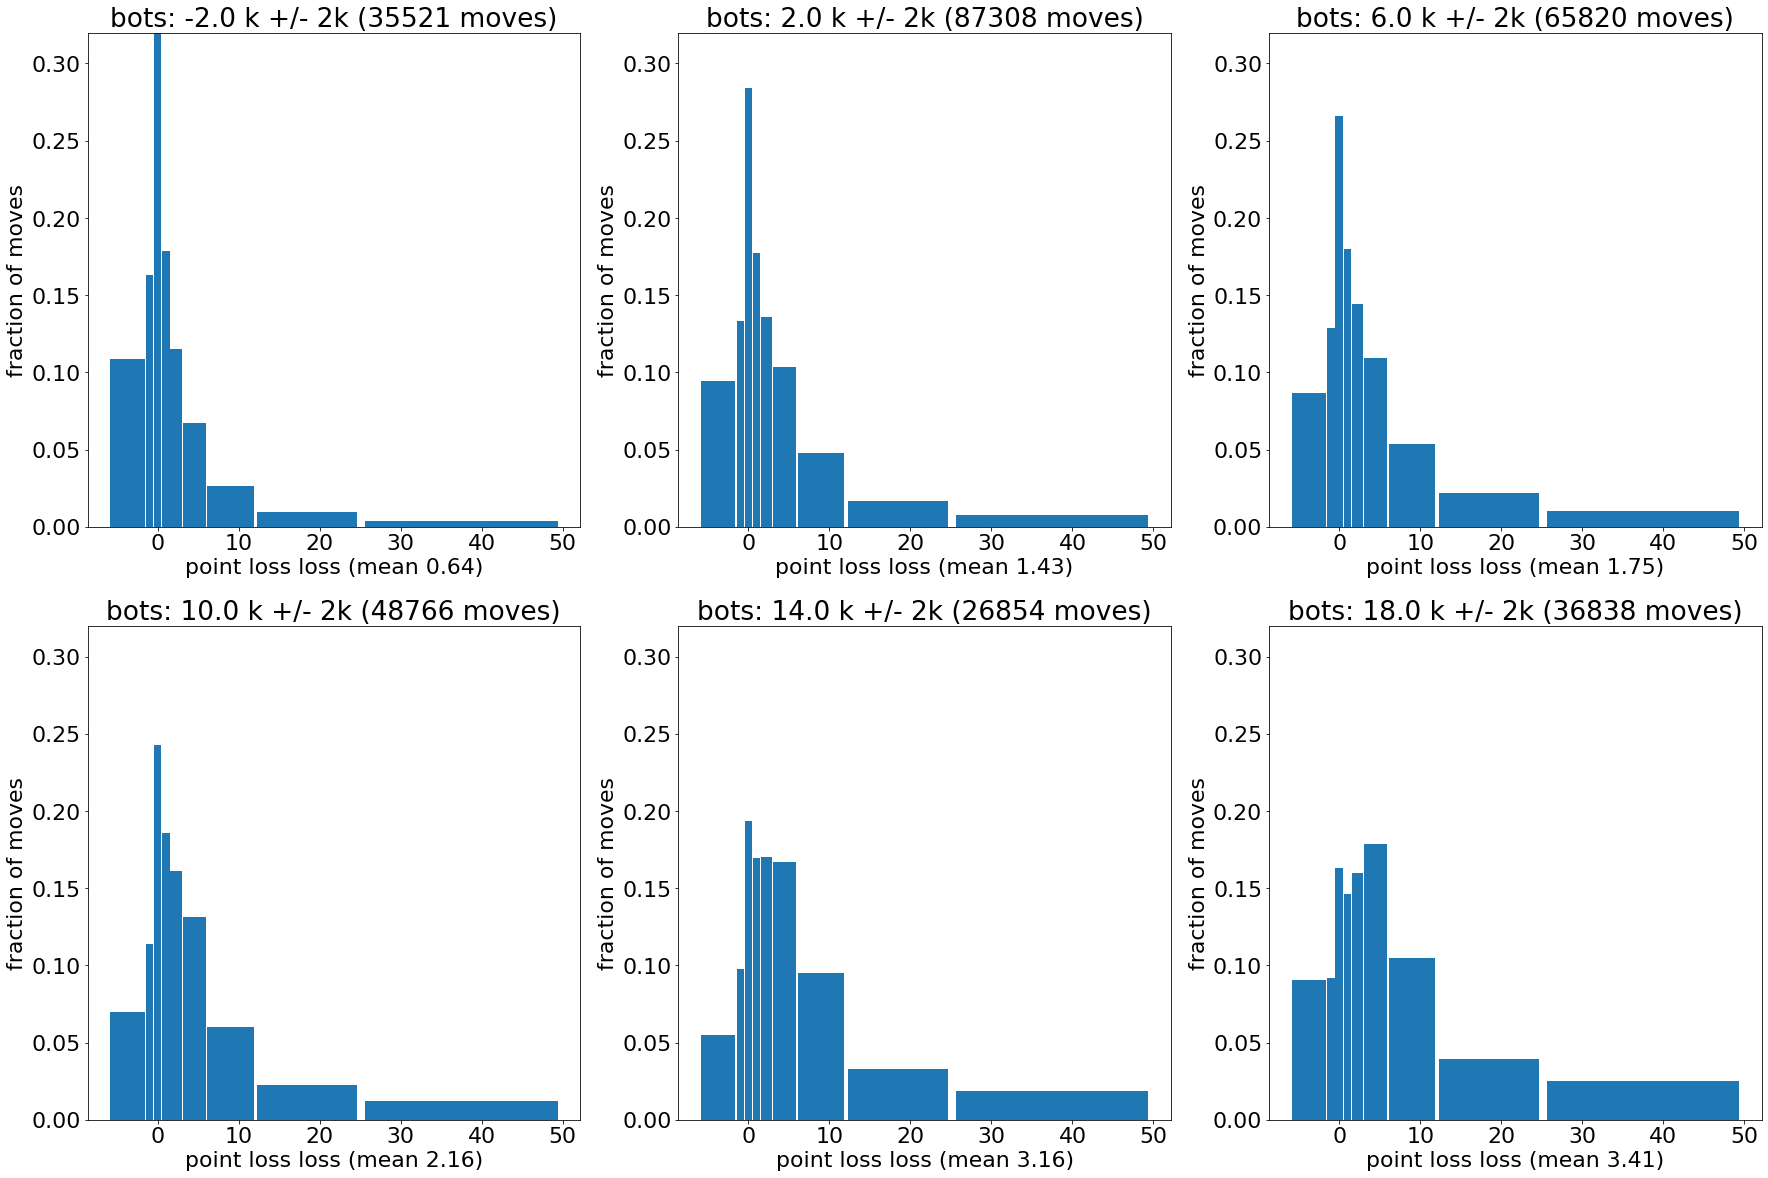

In [17]:
for i,moves in enumerate([user_moves,bot_moves]):
    s = 1
    plt.figure(figsize=(30,20))
    binned_rank = ((moves['rank']-2)/4).round()*4+2
    for r,df in moves[(binned_rank >= -2) & (binned_rank <= 18)].groupby(binned_rank):
        plt.subplot(2, 3, s); s=s+1
        normalized_histogram(df.points_lost.clip(-6,50),bins=[-6,-1.5,-0.5,0.5,1.5,3,6,12,25,50],rwidth=0.95)
        plt.title(f"{labels[i]}: {r} k +/- 2k ({df.shape[0]} moves)")
        plt.xlabel(f"point loss loss (mean {df.points_lost.mean():.2f})")
        plt.ylabel('fraction of moves')
        plt.ylim([0,0.32])

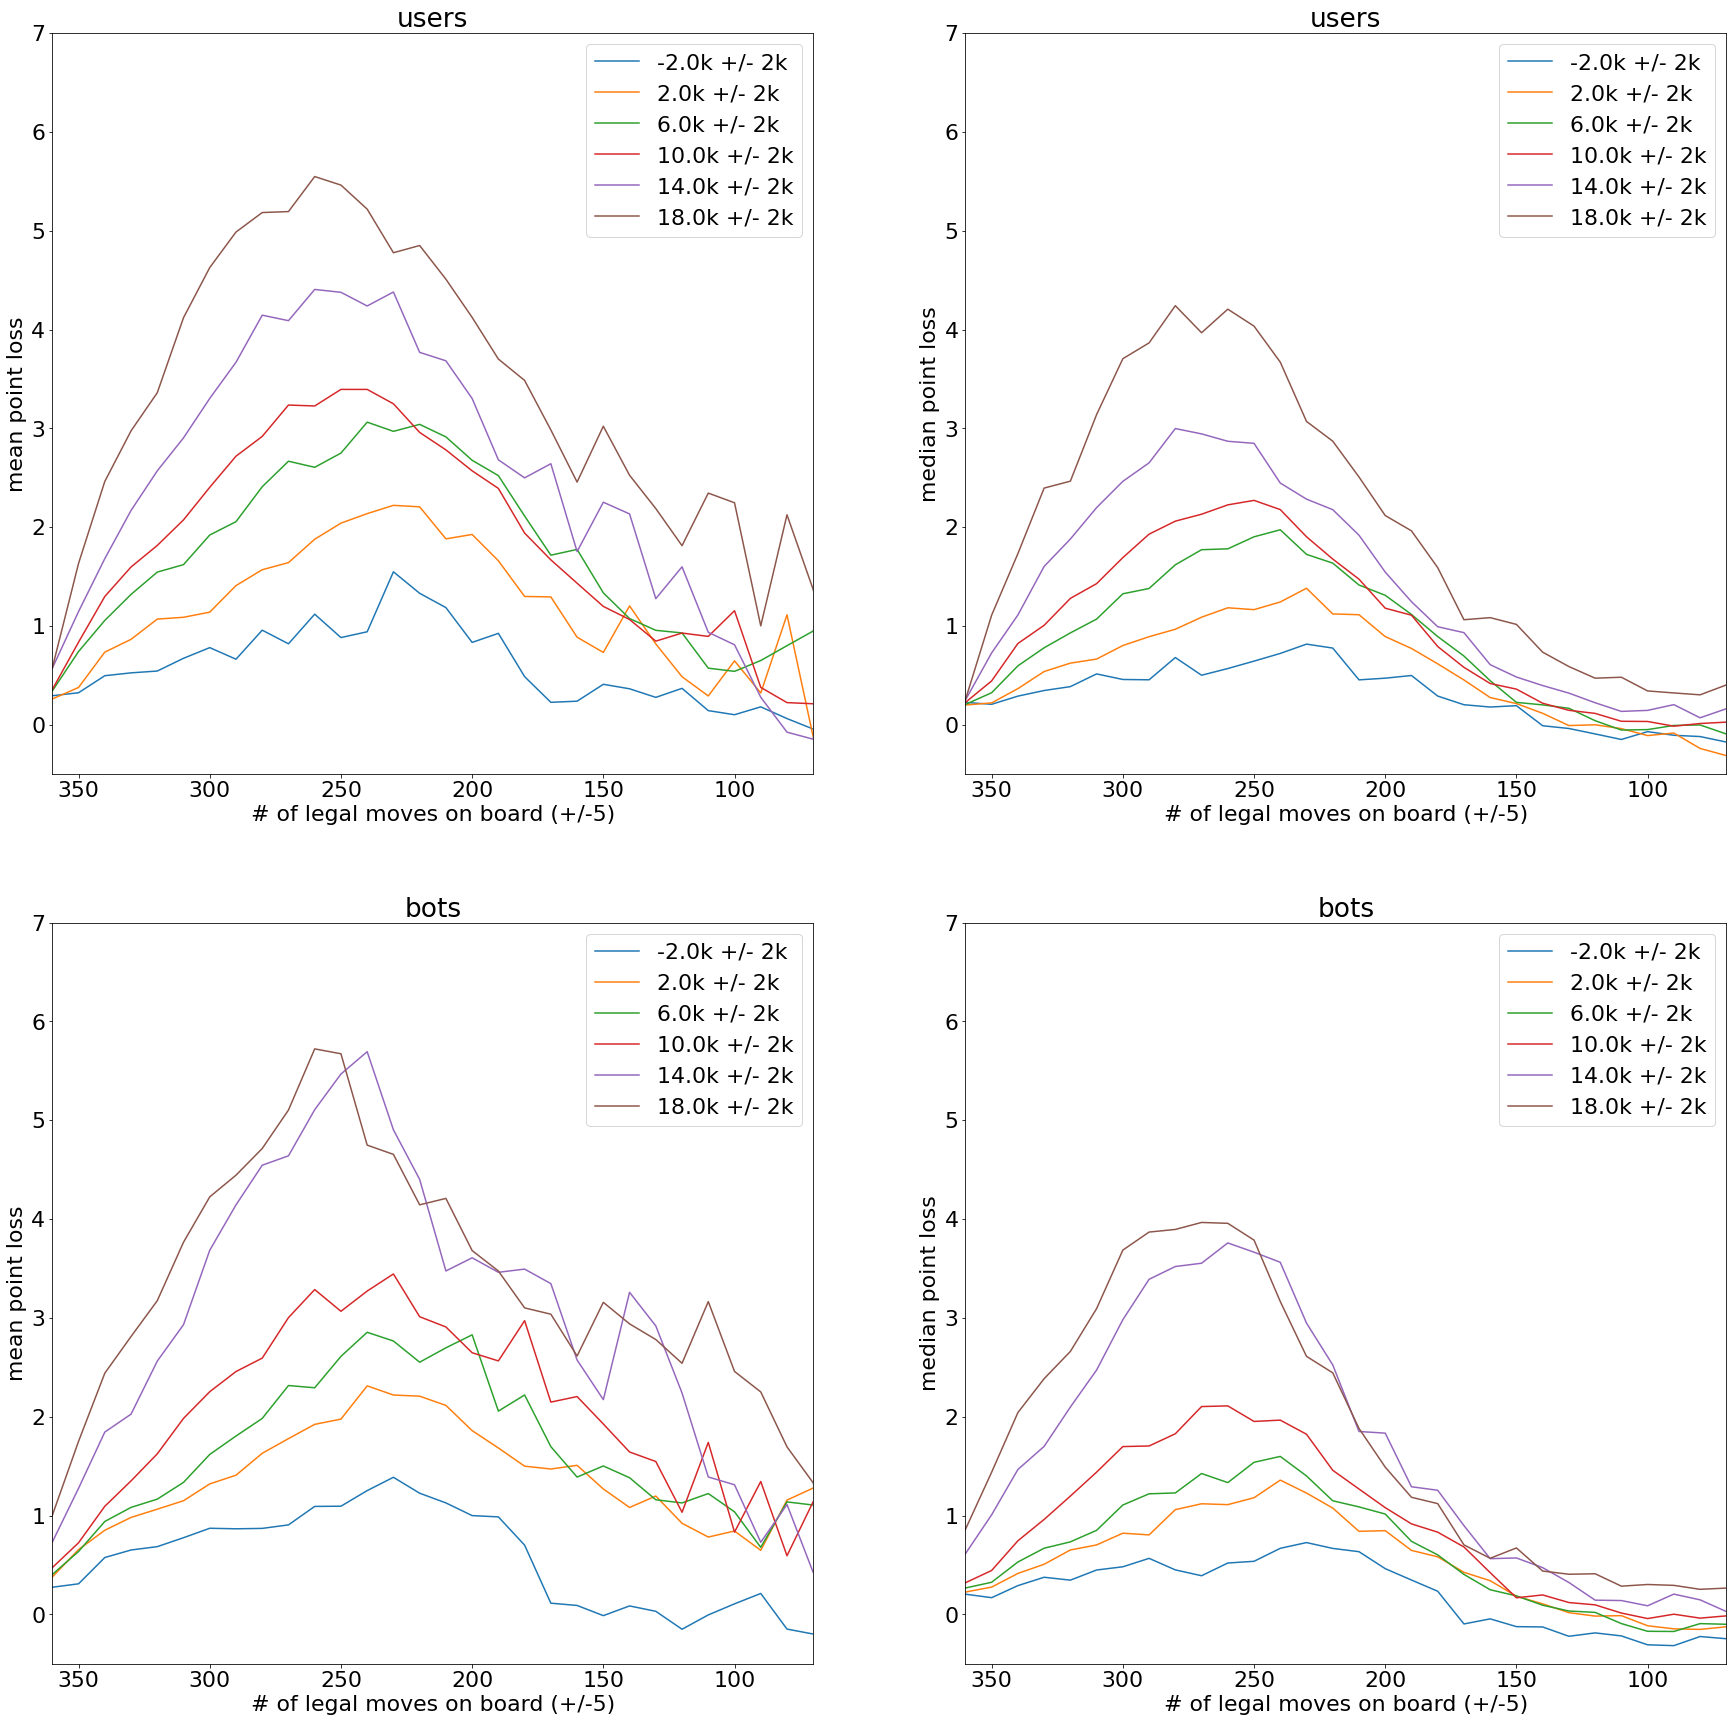

In [18]:
_, axs = plt.subplots(2,2,figsize=(30,30))
for i,moves in enumerate([user_moves,bot_moves]):
    binned_rank = ((moves['rank']-2)/4).round()*4+2
    legends = []
    for r,rdf in moves[(binned_rank >= -2) & (binned_rank <= 18)].groupby(binned_rank):
        binned_num_legal = (rdf.num_legal + 5) // 10
        m = rdf.groupby(binned_num_legal).points_lost.mean()
        axs[i][0].plot(m.index*10,m.values)
        m = rdf.groupby(binned_num_legal).points_lost.median()
        axs[i][1].plot(m.index*10,m.values)
        legends.append(f"{r}k +/- 2k")
    for s in range(2):
        axs[i][s].legend(legends)
        axs[i][s].set_title(labels[i])
        axs[i][s].set_xlabel(f"# of legal moves on board (+/-5)")
        axs[i][s].set_xlim(360,70) # sample size too small after
        axs[i][s].set_ylim(-0.5,7)
    axs[i][0].set_ylabel("mean point loss")
    axs[i][1].set_ylabel("median point loss")